In [1]:
import gymnasium as gym
import torch
import torch.optim as optim
import numpy as np
import time

import matplotlib.pyplot as plt

import my_package
from my_package.core.AC_v3 import AC_agent

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

gamma = 0.99

lr_actor = 1e-4
lr_critic = 1e-4
tau = 0.001

buffer_size = 1000000
batch_size = 256

max_episodes = 300
data_window = 10


env_name = 'ShipUniCont-v1'
Options = {
    'generate_random_ship':             True,
    'workspace_safe_distance':          2,
    'ship_scale_factor':                0.9,
    'segments_lenght':                  0.25,
    'frame_per_step':                   10,
    'init_pose':                        None,
    'agent_radius':                     0.1,
    'v_surge_max':                      0.2,
    'n_actions':                        2,
    'frontal_safe_distance':            0.5,
    'lidar_params':                     {'n_beams': 10, 'max_range': 2.0, 'FoV': np.pi/2},
    'draw_lidar':                       True,
    'max_steps':                        2000
}	

""" Init env """
env = gym.make(env_name, Options=Options)
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]

""" Init AC agent """
agent = AC_agent(
    state_size=state_dim,
    action_size=action_dim,
    gamma=gamma,
    tau=tau,
    lr_actor=lr_actor,
    lr_critic=lr_critic,
    device=device,
    noise_type='param',
    noise_decay=False,
    buffer_size=buffer_size,
    batch_size=batch_size,
    max_episodes=max_episodes,
    desired_distance=0.1,
    n_learn=8,
)

""" Data collect variables """
total_rewards = np.zeros(max_episodes)
noise_history = np.zeros(max_episodes)
len_episodes = np.zeros(max_episodes)
critic_loss_history = []
actor_loss_history = []
coverage_per_ep = np.zeros(max_episodes)

In [3]:
start_time = time.time()

for episode in range(max_episodes):
    state, info = env.reset()
    agent.reset(episode)
    done = False
    
    while not done:
        action = agent.act(state)
        next_state, reward, terminated, truncated, info = env.step(action)
        agent.step(state, action, reward, next_state, terminated)

        total_rewards[episode] += reward
        len_episodes[episode] += 1
        state = next_state
        done = terminated or truncated

    coverage_per_ep[episode] = info['coverage']
    
    if episode % data_window == 0 and episode != 0:
        ma_reward = np.mean(total_rewards[episode-data_window:episode])
        ma_coverage = np.mean(coverage_per_ep[episode-data_window:episode])
        print(f"Ep {episode}/{max_episodes}, MA Reward: {ma_reward:.2f}, MA Coverage: {ma_coverage:.1f} %")

env.close()

total_time_seconds = time.time() - start_time
hours = int(total_time_seconds // 3600)
minutes = int((total_time_seconds % 3600) // 60)
seconds = int(total_time_seconds % 60)
print(f"Training finito in: {hours} ore {minutes} minuti e {seconds} secondi")

Ep 10/300, MA Reward: -19.47, MA Coverage: 13.5 %
Ep 20/300, MA Reward: -23.84, MA Coverage: 3.5 %
Ep 30/300, MA Reward: -21.58, MA Coverage: 8.7 %
Ep 40/300, MA Reward: -21.43, MA Coverage: 9.3 %
Ep 50/300, MA Reward: -21.84, MA Coverage: 8.9 %
Ep 60/300, MA Reward: -21.64, MA Coverage: 9.1 %
Ep 70/300, MA Reward: -26.82, MA Coverage: 4.6 %
Ep 80/300, MA Reward: -25.43, MA Coverage: 0.9 %
Ep 90/300, MA Reward: -25.13, MA Coverage: 1.5 %
Ep 100/300, MA Reward: -25.64, MA Coverage: 1.7 %
Ep 110/300, MA Reward: -25.19, MA Coverage: 2.2 %
Ep 120/300, MA Reward: -24.84, MA Coverage: 2.2 %
Ep 130/300, MA Reward: -25.13, MA Coverage: 4.6 %
Ep 140/300, MA Reward: -24.50, MA Coverage: 5.9 %
Ep 150/300, MA Reward: -25.67, MA Coverage: 0.4 %
Ep 160/300, MA Reward: -23.98, MA Coverage: 4.8 %
Ep 170/300, MA Reward: -27.41, MA Coverage: 2.6 %
Ep 180/300, MA Reward: -28.70, MA Coverage: 6.1 %
Ep 190/300, MA Reward: -19.19, MA Coverage: 24.3 %
Ep 200/300, MA Reward: -18.89, MA Coverage: 15.4 %
Ep 210

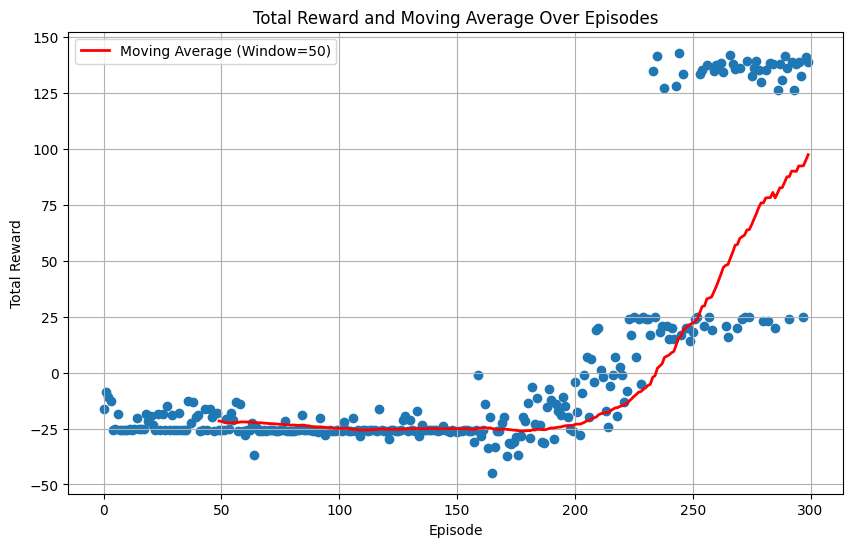

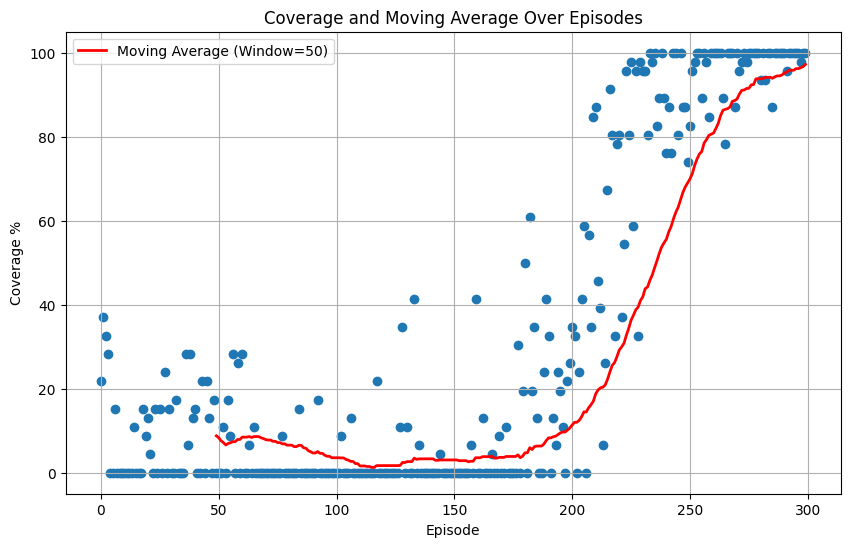

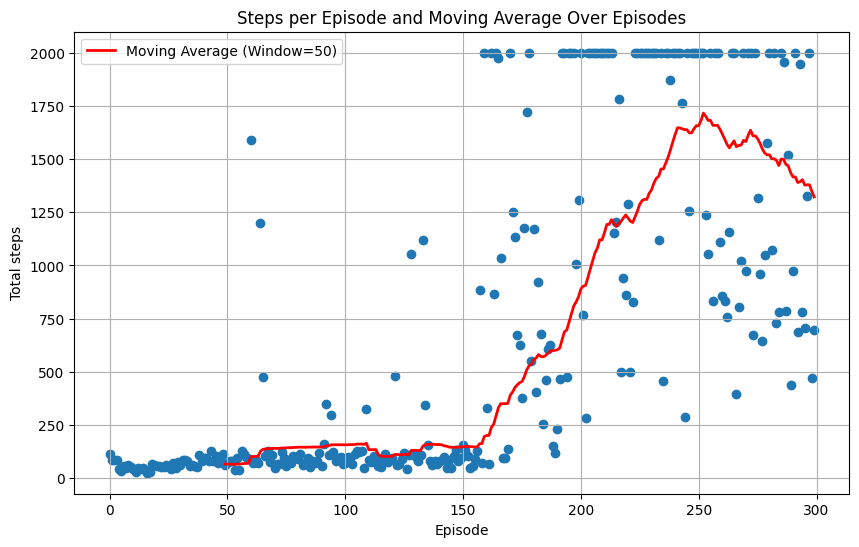

In [4]:
""" Plot rewards """
window_size = 50
ma_reward = np.convolve(total_rewards, np.ones(window_size) / window_size, mode='valid')
plt.figure(figsize=(10, 6))
plt.scatter(np.arange(len(total_rewards)), total_rewards)
plt.plot(np.arange(window_size - 1, len(total_rewards)), ma_reward, color='red', label=f'Moving Average (Window={window_size})', linewidth=2)
plt.title('Total Reward and Moving Average Over Episodes')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.legend()
plt.grid(True)
plt.show()


""" Plot coverage """
window_size = 50
ma_coverage = np.convolve(coverage_per_ep, np.ones(window_size) / window_size, mode='valid')
plt.figure(figsize=(10, 6))
plt.scatter(np.arange(len(coverage_per_ep)), coverage_per_ep)
plt.plot(np.arange(window_size - 1, len(coverage_per_ep)), ma_coverage, color='red', label=f'Moving Average (Window={window_size})', linewidth=2)
plt.title('Coverage and Moving Average Over Episodes')
plt.xlabel('Episode')
plt.ylabel('Coverage %')
plt.legend()
plt.grid(True)
plt.show()

""" Plot episode duration """
window_size = 50
ma_steps = np.convolve(len_episodes, np.ones(window_size) / window_size, mode='valid')
plt.figure(figsize=(10, 6))
plt.scatter(np.arange(len(len_episodes)), len_episodes)
plt.plot(np.arange(window_size - 1, max_episodes), ma_steps, color='red', label=f'Moving Average (Window={window_size})', linewidth=2)
plt.title('Steps per Episode and Moving Average Over Episodes')
plt.xlabel('Episode')
plt.ylabel('Total steps')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
env = gym.make(env_name, Options=Options, render_mode='human')

for ep in range(2):
    state, info = env.reset()
    agent.reset()
    done = False
    total_reward = 0
    steps = 0
    while not done:
        action = agent.act(state, add_noise=True)
        next_state, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated
        state = next_state
        total_reward += reward
        
    if info['collision']:
        ending_cause = "collision"
    elif info['out_of_bounds']:
        ending_cause = "out of bounds"
    elif info['time_limit']:
        ending_cause = "max steps reached"
    elif info['coverage'] == 100:
        ending_cause = "100% coverage"
    else:
        ending_cause = "unkown"
    print('total reward: ' + str(total_reward) + ' end episode for: ' + ending_cause)
env.close()

total reward: 140.75000000000003 end episode for: 100% coverage


In [5]:
checkpoint = {
    'gamma' : gamma,
    'state_dim': state_dim,
    'action_dim': action_dim,
    'actor_lr': lr_actor,
    'critic_lr': lr_critic,
    'tau' : tau,
    'buffer_size' : buffer_size,
    'batch_size' : batch_size,
    'max_episodes' : max_episodes,
    'actor_state_dict': agent.actor.state_dict(),
    'critic_state_dict': agent.critic.state_dict(),
    'total_rewards': total_rewards,
    'len_episodes' : len_episodes,
    'coverage_per_ep': coverage_per_ep,
    'Options' : Options,
    'env_name': env_name,
    'AC_version': 'AC_v3',
    'noise_type' : agent.noise_type,
    'desired_distance' : agent.desired_distance,
}

path = "ShipUniCont_v0/" + env_name + "_" + str(max_episodes) + "_ep_" + str(action_dim) + "_actions_AC_v3.0_param_noise_v_max_massima.pth"
torch.save(checkpoint, path)